In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D
from tensorflow.keras.layers import SpatialDropout1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
# Loading the DSs 
df_test = pd.read_csv('cleaned_datatest.csv')
df_val = pd.read_csv('datavalidation.csv')
df_train = pd.read_csv('datatraining.csv')
df_train.head()

,Temperature,Humidity,CO2,Occupancy,weekend,tod_sin,tod_cos
0,23.18,27.2720,721.25,1,0,-0.999229,-0.039260
1,23.15,27.2675,714.00,1,0,-0.999229,-0.039260
2,23.15,27.2450,713.50,1,0,-0.999534,-0.030539
3,23.15,27.2000,708.25,1,0,-0.999657,-0.026177
4,23.10,27.2000,704.50,1,0,-0.999762,-0.021815


In [3]:
print(df_train.duplicated().sum())
print(df_val.duplicated().sum())
print(df_test.duplicated().sum())

1
0
5


In [19]:
for df in [df_train, df_test]:
    df.drop_duplicates(inplace=True)

In [ ]:
# Preparing data for CNN model,
target = 'Occupancy'
features = ["Temperature", "Humidity", "CO2", "weekend", "tod_sin", "tod_cos"]

X_train = df_train[features].values
y_train = df_train[target].values.astype(int)

X_val = df_val[features].values
y_val = df_val[target].values.astype(int)

X_test = df_test[features].values
y_test = df_test[target].values.astype(int)

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Scaling the features, I will fit only the train  DS
# Because the weekend is binary and tod_sin, tod_cos are already normialized, to -1 , 1. So I will Standardize the continuous features.
scaler = StandardScaler()
X_train_scaled[:, 0:3] = scaler.fit_transform(X_train_scaled[:, 0:3])

# transforming val and test DS 
X_val_scaled[:, 0:3] = scaler.transform(X_val_scaled[:, 0:3])
X_test_scaled[:, 0:3]= scaler.transform(X_test_scaled[:, 0:3])

print("Train:", X_train_scaled.shape, y_train.shape)
print("Val:", X_val_scaled.shape, y_val.shape)
print("Test:", X_test_scaled.shape, y_test.shape)

Train: (8117, 6) (8117,)
Val: (2663, 6) (2663,)
Test: (9720, 6) (9720,)


In [ ]:
# Checking the weekend and tod_sin, tod_cos. 
print("weekend unique:", np.unique(X_train_scaled[:,3]))
print("tod_sin min/max:", X_train_scaled[:,4].min(), X_train_scaled[:,4].max())
print("tod_cos min/max:", X_train_scaled[:,5].min(), X_train_scaled[:,5].max())

weekend unique: [0. 1.]
tod_sin min/max: -1.0 1.0
tod_cos min/max: -1.0 1.0


In [15]:
# MAKING SEQUENCES:
# The CNN model for time series, needs sequences as input 
# I will create windows of minutes that the model will predict right after the window, the next minute

# Creating function
def windows_time(X, y, window_size = None, step_ahead = None):
   # I will creaate two lists for storing  features and the target
   # The end should start the a window
   X_windows = []
   y_windows = []
   last_start = len(X) - window_size - step_ahead + 1
   for start in range(last_start):
        end = start + window_size
        X_windows.append(X[start:end])                  
        y_windows.append(y[end + step_ahead - 1])      
   return np.array(X_windows), np.array(y_windows)

window_size = 20
step_ahead = 1

  
X_train_window, y_train_window = windows_time(X_train_scaled, y_train, window_size, step_ahead)
X_val_window, y_val_window = windows_time(X_val_scaled, y_val, window_size, step_ahead)
X_test_window, y_test_window = windows_time(X_test_scaled,y_test, window_size, step_ahead)

In [16]:
print("Train windows:", X_train_window.shape, y_train_window.shape)
print("Val windows:", X_val_window.shape,y_val_window.shape)
print("Test windows:", X_test_window.shape, y_test_window.shape)

Train windows: (8097, 20, 6) (8097,)
Val windows: (2643, 20, 6) (2643,)
Test windows: (9700, 20, 6) (9700,)


In [24]:
# let me to check the label.
np.unique(y_train_window)

array([0, 1])

In [9]:
# The target column is binary, and the classes are imbalanced
# one way is to use class weights during training that the model learn fairly both classes
# Counting each class  
classes, counts = np.unique(y_train_window, return_counts=True)
print("Window label counts:", dict(zip(classes, counts)))
print("Positive rate:", counts[1] / counts.sum() if len(counts) > 1 else 0.0)

# Counting class weights: 
all_classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=all_classes, y=y_train_window)
class_weight = {0: float(weights[0]), 1: float(weights[1])}
print("Class weights:", class_weight)

Window label counts: {np.int64(0): np.int64(6384), np.int64(1): np.int64(1713)}
Positive rate: 0.21155983697665803
Class weights: {0: 0.6341635338345865, 1: 2.363397548161121}


In [10]:
model = tf.keras.Sequential([
    layers.Input(shape=(20, 6)),
    layers.Conv1D(32, kernel_size=3, padding='same', activation="relu", kernel_regularizer=l2(0.0001)),
    layers.MaxPooling1D(pool_size=2),
    layers.SpatialDropout1D(0.2),
    layers.Conv1D(64, kernel_size=3, padding='causal', activation="relu", kernel_regularizer=l2(0.0001)),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 32)         │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 10, 32)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,881 (26.88 KB)

 Trainable params: 6,881 (26.88 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", 
    metrics=[
            # this is a good option for imbalanced,       
        tf.keras.metrics.AUC(curve='PR', name="auc_pr"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")])


# sources:
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
# Reducing learning rate when stuck
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  factor=0.5, patience=2, verbose=1)

In [13]:
history = model.fit(X_train_window, y_train_window, 
    epochs=80, batch_size=128, callbacks=[early_stop, reduce_lr], class_weight=class_weight,
    validation_data=(X_val_window, y_val_window), verbose=2, shuffle=True)

Epoch 1/80
64/64 - 2s - 29ms/step - auc_pr: 0.4300 - loss: 0.6431 - precision: 0.3480 - recall: 0.7647 - val_auc_pr: 0.8591 - val_loss: 0.6183 - val_precision: 0.6917 - val_recall: 0.9475 - learning_rate: 1.0000e-04
Epoch 2/80
64/64 - 0s - 4ms/step - auc_pr: 0.6925 - loss: 0.5231 - precision: 0.5892 - recall: 0.8926 - val_auc_pr: 0.8724 - val_loss: 0.5443 - val_precision: 0.7069 - val_recall: 0.9296 - learning_rate: 1.0000e-04
Epoch 3/80
64/64 - 0s - 4ms/step - auc_pr: 0.7726 - loss: 0.4166 - precision: 0.6482 - recall: 0.8949 - val_auc_pr: 0.8920 - val_loss: 0.4687 - val_precision: 0.7321 - val_recall: 0.9328 - learning_rate: 1.0000e-04
Epoch 4/80
64/64 - 0s - 3ms/step - auc_pr: 0.8186 - loss: 0.3291 - precision: 0.7081 - recall: 0.9119 - val_auc_pr: 0.8969 - val_loss: 0.4008 - val_precision: 0.7623 - val_recall: 0.9433 - learning_rate: 1.0000e-04
Epoch 5/80
64/64 - 0s - 4ms/step - auc_pr: 0.8489 - loss: 0.2679 - precision: 0.7603 - recall: 0.9241 - val_auc_pr: 0.9090 - val_loss: 0.34

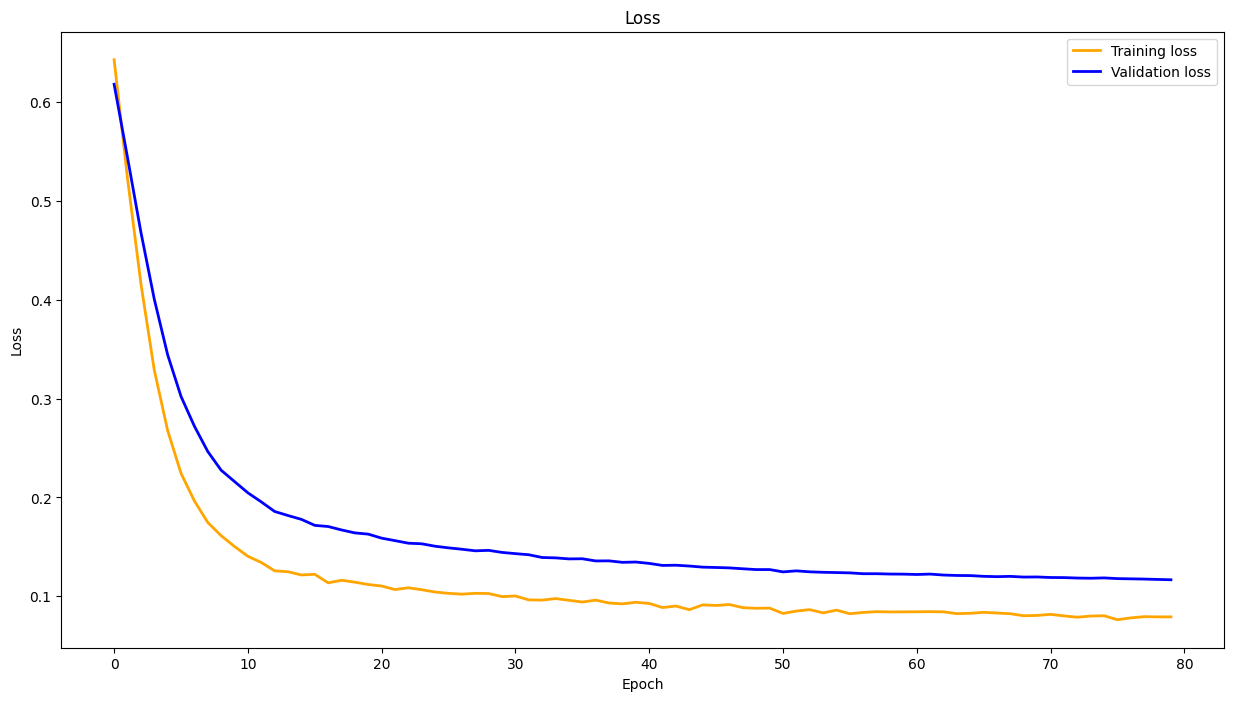

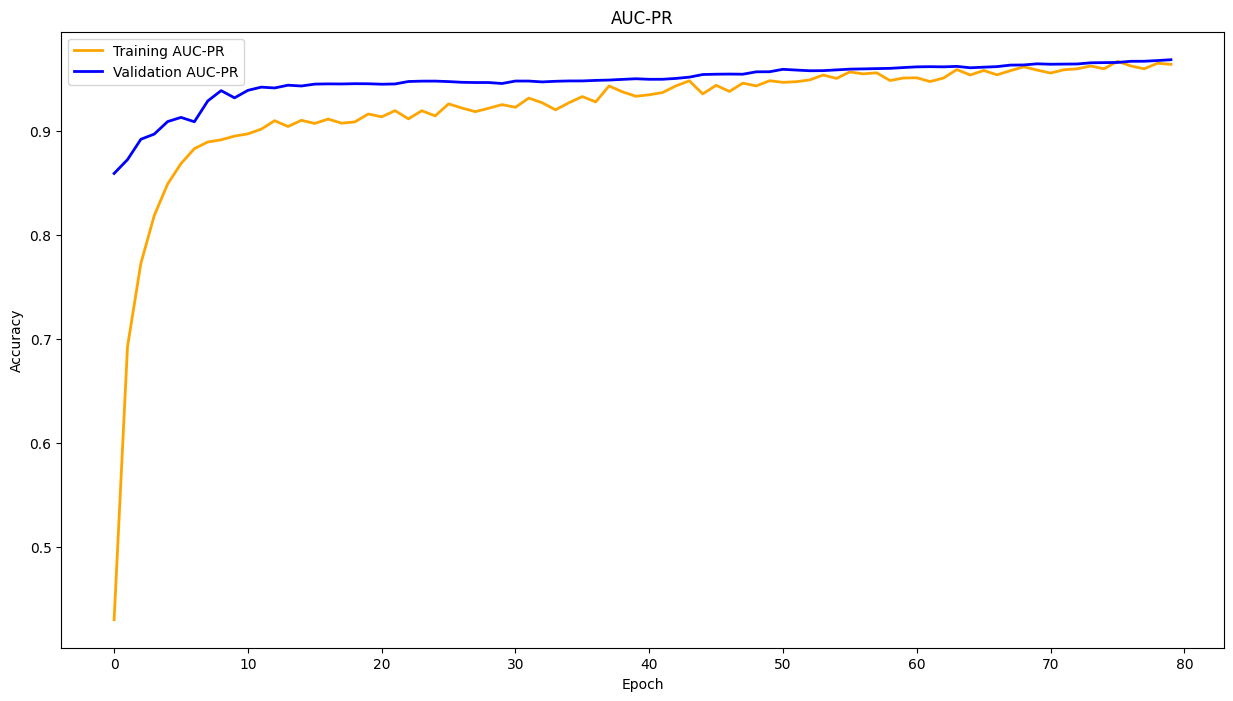

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['loss'], label='Training loss', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_loss'], label='Validation loss', color='blue', linewidth=2, markersize=6)
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(history.history['auc_pr'], label='Training AUC-PR', color='orange', linewidth=2, markersize=6)
ax.plot(history.history['val_auc_pr'], label='Validation AUC-PR', color='blue', linewidth=2, markersize=6)
ax.set_title('AUC-PR')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()